# Setup

In [1]:
import pandas as pd
import pandas_profiling as pdprof
import numpy as np
import matplotlib.pyplot as plt
from os.path import expanduser 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import svm
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.inspection import plot_partial_dependence

import xgboost as xgb

# GLM from statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from ipywidgets import FloatProgress
from IPython.display import display

In [2]:
%matplotlib inline

In [3]:
# Ggplot Style
plt.style.use('ggplot')

In [4]:
# Set Plot Dimensions (overall)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Data Preparation

In [6]:
home_dir = expanduser("~")
data_dir = "/Data/"

filename = home_dir+data_dir+"WA_Fn-UseC_-Telco-Customer-Churn.csv"

churn_raw_df = pd.read_csv(filename)
churn_raw_df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [6]:
churn_raw_df['len_TotalCharges'] = churn_raw_df['TotalCharges'].apply(len)

In [7]:
churn_raw_df[['TotalCharges','len_TotalCharges']]

TotalCharges  len_TotalCharges
0           29.85                 5
1          1889.5                 6
2          108.15                 6
3         1840.75                 7
4          151.65                 6
...           ...               ...
7038       1990.5                 6
7039       7362.9                 6
7040       346.45                 6
7041        306.6                 5
7042       6844.5                 6

[7043 rows x 2 columns]

In [8]:
churn_raw_df[churn_raw_df.len_TotalCharges==1]['TotalCharges']

488      
753      
936      
1082     
1340     
3331     
3826     
4380     
5218     
6670     
6754     
Name: TotalCharges, dtype: object

In [9]:
churn_raw_df.loc[churn_raw_df.len_TotalCharges==1, 'TotalCharges'] = '0.0'

In [10]:
churn_raw_df['TotalCharges'].apply(len).unique()

array([5, 6, 7, 4, 2, 3])

In [11]:
churn_raw_df['TotalCharges'].astype('float64')

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [12]:
churn_raw_df['TotalCharges'] = churn_raw_df['TotalCharges'].astype('float64')

In [13]:
churn_raw_df['Churn'].apply(len).unique()

array([2, 3])

## Profiling

In [14]:
churn_raw_df.profile_report(style={'full_width':True})

## One-Hot Encoding 

In [16]:
# object var

object_var_list = []
numeric_var_list = []

for elem in zip(churn_raw_df.columns,churn_raw_df.dtypes):
    if elem[1]=='object' and elem[0]!='customerID':
        object_var_list.append(elem[0])
        
for elem in zip(churn_raw_df.columns,churn_raw_df.dtypes):
    if elem[1]!='object' and elem[0]!='len_TotalCharges':
        numeric_var_list.append(elem[0])

In [17]:
churn_numeric_df = churn_raw_df[numeric_var_list]

In [18]:
for var in object_var_list:
    print(churn_raw_df[var].unique())

['Female' 'Male']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No phone service' 'No' 'Yes']
['DSL' 'Fiber optic' 'No']
['No' 'Yes' 'No internet service']
['Yes' 'No' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['Month-to-month' 'One year' 'Two year']
['Yes' 'No']
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
['No' 'Yes']


In [19]:
tmp_df = churn_numeric_df.copy()

for var in object_var_list:
    tmp_dummy_df = pd.get_dummies(churn_raw_df[var], prefix=var, drop_first=True)
    tmp_df = pd.concat([tmp_df,tmp_dummy_df], axis=1)

In [20]:
tmp_df

SeniorCitizen  tenure  MonthlyCharges  TotalCharges  gender_Male  \
0                 0       1           29.85         29.85            0   
1                 0      34           56.95       1889.50            1   
2                 0       2           53.85        108.15            1   
3                 0      45           42.30       1840.75            1   
4                 0       2           70.70        151.65            0   
...             ...     ...             ...           ...          ...   
7038              0      24           84.80       1990.50            1   
7039              0      72          103.20       7362.90            0   
7040              0      11           29.60        346.45            0   
7041              1       4           74.40        306.60            1   
7042              0      66          105.65       6844.50            1   

      Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0               1               0                 0   
1               0               0                 1   
2               0               0                 1   
3               0               0                 0   
4               0               0                 1   
...           ...             ...               ...   
7038            1               1                 1   
7039            1               1                 1   
7040            1               1                 0   
7041            1               0                 1   
7042            0               0                 1   

      MultipleLines_No phone service  MultipleLines_Yes  ...  StreamingTV_Yes  \
0                                  1                  0  ...                0   
1                                  0                  0  ...                0   
2                                  0                  0  ...                0   
3                                  1                  0  ...                0   
4                                  0                  0  ...                0   
...                              ...                ...  ...              ...   
7038                               0                  1  ...                1   
7039                               0                  1  ...                1   
7040                               1                  0  ...                0   
7041                               0                  1  ...                0   
7042                               0                  0  ...                1   

      StreamingMovies_No internet service  StreamingMovies_Yes  \
0                                       0                    0   
1                                       0                    0   
2                                       0                    0   
3                                       0                    0   
4                                       0                    0   
...                                   ...                  ...   
7038                                    0                    1   
7039                                    0                    1   
7040                                    0                    0   
7041                                    0                    0   
7042                                    0                    1   

      Contract_One year  Contract_Two year  PaperlessBilling_Yes  \
0                     0                  0                     1   
1                     1                  0                     0   
2                     0                  0                     1   
3                     1                  0                     0   
4                     0                  0                     1   
...                 ...                ...                   ...   
7038                  1                  0                     1   
7039                  1                  0                     1   
7040                  0                  0                     1   
7041      

In [21]:
# Final dataset

churn_df = tmp_df.rename(columns={'Churn_Yes':'Churn'})

In [22]:
churn_df.groupby('Churn')['Churn'].count()

Churn
0    5174
1    1869
Name: Churn, dtype: int64

## Dataset Building (churn_df)

In [159]:
features = churn_df.columns[:-1].values
target = churn_df.columns[-1]

X = churn_df[features]
y = churn_df[target]

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [161]:
X_train.sample(n=10)

SeniorCitizen  tenure  MonthlyCharges  TotalCharges  gender_Male  \
5033              0       1           19.40         19.40            0   
2867              0      24           20.45        527.35            0   
625               0      25           95.15       2395.70            0   
6986              0      30           94.10       2804.45            0   
785               1      46          110.00       4874.80            0   
2608              0       7           34.50        279.25            1   
5439              1      32           96.15       3019.25            1   
2131              0      42           48.15       2032.30            1   
1944              0       8           25.50        215.20            1   
2427              0       1           35.90         35.90            1   

      Partner_Yes  Dependents_Yes  PhoneService_Yes  \
5033            0               0                 1   
2867            0               0                 1   
625             1               0                 1   
6986            1               0                 1   
785             0               0                 1   
2608            1               1                 0   
5439            0               0                 1   
2131            1               1                 0   
1944            0               1                 0   
2427            0               0                 0   

      MultipleLines_No phone service  MultipleLines_Yes  ...  \
5033                               0                  0  ...   
2867                               0                  0  ...   
625                                0                  0  ...   
6986                               0                  1  ...   
785                                0                  1  ...   
2608                               1                  0  ...   
5439                               0                  1  ...   
2131                               1                  0  ...   
1944                               1                  0  ...   
2427                               1                  0  ...   

      StreamingTV_No internet service  StreamingTV_Yes  \
5033                                1                0   
2867                                1                0   
625                                 0                1   
6986                                0                1   
785                                 0                1   
2608                                0                0   
5439                                0                1   
2131                                0                1   
1944                                0                0   
2427                                0                0   

      StreamingMovies_No internet service  StreamingMovies_Yes  \
5033                                    1                    0   
2867                                    1                    0   
625                                     0                    1   
6986                                    0                    0   
785                                     0                    1   
2608                                    0                    0   
5439                                    0                    1   
2131                                    0                    0   
1944                                    0                    0   
2427                                    0                    1   

      Contract_One year  Contract_Two year  PaperlessBilling_Yes  \
5033                  0                  0                     1   
2867                  1                  0                     0   
625                   0                  0                     1   
6986                  0                  0                     1   
785                   1                  0                     1   
2608                  0                  0                     1   
5439                  0               

## Dataset Building (augmented churn_df)

In [340]:
#new_feature = churn_df['tenure'] - 1/3*churn_df['Partner_Yes']*churn_df['MonthlyCharges']
new_feature = 1/2*churn_df['tenure']

In [341]:
churn_df_augmented = churn_df.copy()

#churn_df_augmented['new_feature'] = new_feature
churn_df_augmented.insert(2,'new_feature',new_feature)

churn_df_augmented.head()

SeniorCitizen  tenure  new_feature  MonthlyCharges  TotalCharges  \
0              0       1          0.5           29.85         29.85   
1              0      34         17.0           56.95       1889.50   
2              0       2          1.0           53.85        108.15   
3              0      45         22.5           42.30       1840.75   
4              0       2          1.0           70.70        151.65   

   gender_Male  Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0            0            1               0                 0   
1            1            0               0                 1   
2            1            0               0                 1   
3            1            0               0                 0   
4            0            0               0                 1   

   MultipleLines_No phone service  ...  StreamingTV_Yes  \
0                               1  ...                0   
1                               0  ...                0   
2                               0  ...                0   
3                               1  ...                0   
4                               0  ...                0   

   StreamingMovies_No internet service  StreamingMovies_Yes  \
0                                    0                    0   
1                                    0                    0   
2                                    0                    0   
3                                    0                    0   
4                                    0                    0   

   Contract_One year  Contract_Two year  PaperlessBilling_Yes  \
0                  0                  0                     1   
1                  1                  0                     0   
2                  0                  0                     1   
3                  1                  0                     0   
4                  0                  0                     1   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check  Churn  
0                           0      0  
1                           1      0  
2                           1      1  
3                           0      0  
4                           0      1  

[5 rows x 32 columns]

In [342]:
features_augmented = churn_df_augmented.columns[:-1].values
target = churn_df.columns[-1]

X_augmented = churn_df_augmented[features_augmented].values
y = churn_df[target].values

In [343]:
X_train_augmented, X_test_augmented, y_train, y_test = train_test_split(X_augmented, y, test_size = 0.3)

# Model Building

## GBM on dataset churn_df

In [37]:
gbm_model = GradientBoostingClassifier(n_estimators=50, 
                                       max_depth=5,
                                       subsample=0.6)

In [38]:
gbm_model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.6, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [39]:
gbm_model.score(X_test, y_test)

0.8026502602934217

In [40]:
prediction_gbm = gbm_model.predict_proba(X_test)[:,1]
train_gbm = gbm_model.predict_proba(X_train)[:,1]

In [41]:
fpr_gbm_test, tpr_gbm_test, thrsh_gbm_test = roc_curve(y_test, prediction_gbm)
fpr_gbm_train, tpr_gbm_train, thrsh_gbm_train = roc_curve(y_train, train_gbm)

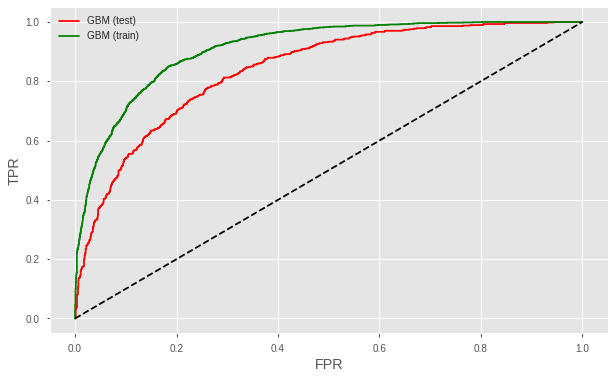

In [42]:
plt.plot(fpr_gbm_test, tpr_gbm_test, c='r', label='GBM (test)');
plt.plot(fpr_gbm_train, tpr_gbm_train, c='g', label='GBM (train)');
plt.xlabel("FPR");plt.ylabel("TPR");
plt.plot(np.linspace(0,1,100),list(map(lambda x: x,np.linspace(0,1,100))),'--',c='black');

plt.legend();

In [43]:
print("AUROC GBM (test) --> {:3.1f}%".format(auc(fpr_gbm_test, tpr_gbm_test)*100))
print("AUROC GBM (train) --> {:3.1f}%".format(auc(fpr_gbm_train, tpr_gbm_train)*100))

AUROC GBM (test) --> 83.9%
AUROC GBM (train) --> 91.0%


In [44]:
gbm_feat_imp_df = pd.DataFrame({'feature':features,'importance':gbm_model.feature_importances_}).sort_values(by='importance',ascending=False)

gbm_feat_imp_df.head(n=20)

feature  importance
1                                tenure    0.249398
3                          TotalCharges    0.184731
2                        MonthlyCharges    0.174197
10          InternetService_Fiber optic    0.127464
28       PaymentMethod_Electronic check    0.041982
25                    Contract_Two year    0.032012
24                    Contract_One year    0.029053
13                   OnlineSecurity_Yes    0.021773
26                 PaperlessBilling_Yes    0.021126
19                      TechSupport_Yes    0.015244
14     OnlineBackup_No internet service    0.008648
21                      StreamingTV_Yes    0.008456
15                     OnlineBackup_Yes    0.007867
23                  StreamingMovies_Yes    0.007749
0                         SeniorCitizen    0.007538
6                        Dependents_Yes    0.007259
22  StreamingMovies_No internet service    0.006896
4                           gender_Male    0.006111
5                           Partner_Yes    0.005934
9                     MultipleLines_Yes    0.005930

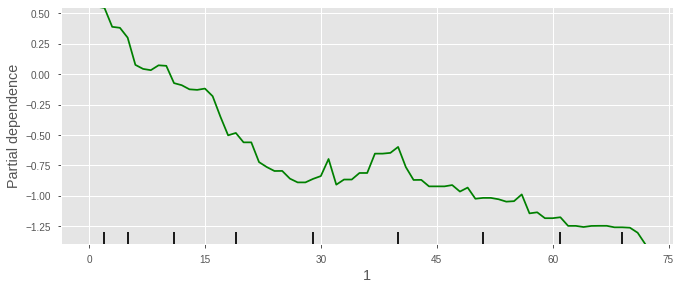

In [45]:
# Churn prob seems to decrease with tenure

plot_partial_dependence(gbm_model, X_test, [1])

In [66]:
# Select only the features with importance over some fixed threshold

_thrsh = 0.01
print("# of features --> {}".format((gbm_feat_imp_df[gbm_feat_imp_df.importance >= _thrsh]['feature'].shape[0])))

restricted_features = gbm_feat_imp_df[gbm_feat_imp_df.importance >= _thrsh]['feature'].values

X_restricted = churn_df[restricted_features]

# of features --> 10


In [67]:
X_restricted_train, X_restricted_test, y_train, y_test = train_test_split(X_restricted, y, test_size = 0.3)

In [68]:
gbm_restricted_model = GradientBoostingClassifier(n_estimators=50)

In [69]:
gbm_restricted_model.fit(X_restricted_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [70]:
gbm_restricted_model.score(X_restricted_test, y_test)

0.792238523426408

In [71]:
prediction_gbm_restricted = gbm_restricted_model.predict_proba(X_restricted_test)[:,1]

In [72]:
fpr_gbm_restricted_test, tpr_gbm_restricted_test, thrsh_gbm_restricted_test = roc_curve(y_test, prediction_gbm_restricted)

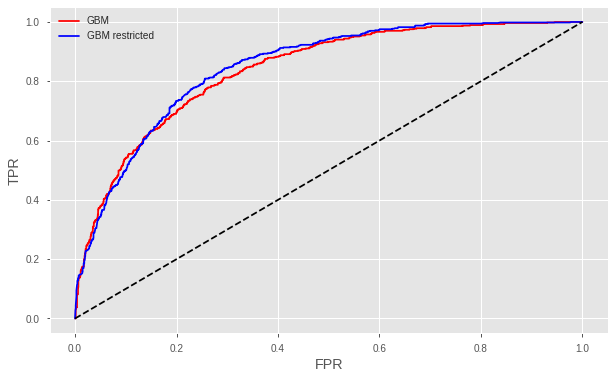

In [73]:
plt.plot(fpr_gbm_test, tpr_gbm_test, c='r', label='GBM');
plt.plot(fpr_gbm_restricted_test, tpr_gbm_restricted_test, c='b', label='GBM restricted');
plt.xlabel("FPR");plt.ylabel("TPR");
plt.plot(np.linspace(0,1,100),list(map(lambda x: x,np.linspace(0,1,100))),'--',c='black');

plt.legend();

In [74]:
print("AUROC GBM (test) --> {:3.1f}%".format(auc(fpr_gbm_test, tpr_gbm_test)*100))
print("AUROC GBM restricted (test) --> {:3.1f}%".format(auc(fpr_gbm_restricted_test, tpr_gbm_restricted_test)*100))

AUROC GBM (test) --> 83.9%
AUROC GBM restricted (test) --> 84.8%


### Variable Restrictions vs Performance

In [75]:
gbm_restricted_model = GradientBoostingClassifier(n_estimators=50)
_thrs_array = np.linspace(0, 0.1, 50)
out_perf_list = []
num_feat_list = []

# Progress Bar 
f = FloatProgress(min=0, max=len(_thrs_array), bar_style='info')
display(f)

for _thrsh in _thrs_array:
    num_restricted_features = gbm_feat_imp_df[gbm_feat_imp_df.importance >= _thrsh]['feature'].shape[0]
    restricted_features = gbm_feat_imp_df[gbm_feat_imp_df.importance >= _thrsh]['feature'].values
    X_restricted = churn_df[restricted_features].values
    
    X_restricted_train, X_restricted_test, y_train, y_test = train_test_split(X_restricted, y, test_size = 0.3, random_state = 712)
    
    gbm_restricted_model.fit(X_restricted_train, y_train)
    prediction_gbm_restricted = gbm_restricted_model.predict_proba(X_restricted_test)[:,1]
    
    fpr_gbm_restricted_test, tpr_gbm_restricted_test, thrsh_gbm_restricted_test = roc_curve(y_test, prediction_gbm_restricted)
    out_perf = auc(fpr_gbm_restricted_test, tpr_gbm_restricted_test)
    out_perf_list.append(out_perf)
    num_feat_list.append(num_restricted_features)
    
    f.value += 1

FloatProgress(value=0.0, bar_style='info', max=50.0)

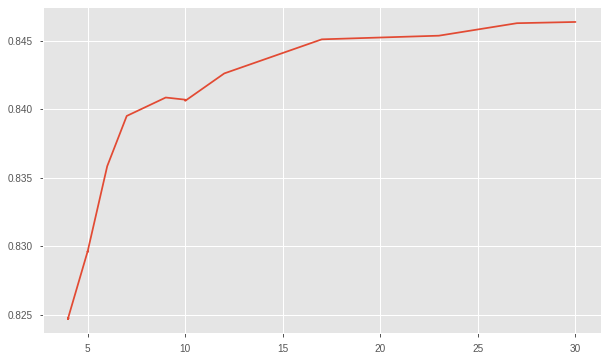

In [76]:
plt.plot(num_feat_list, out_perf_list);

In [77]:
gbm_restricted_model = GradientBoostingClassifier(n_estimators=50)

_thrs_array = np.linspace(0, 0.1, 100)
out_perf_tot = []
nsim = 100

# Progress Bar 
f = FloatProgress(min=0, max=nsim, bar_style='info')
display(f)

for s in np.random.randint(5000,9000,nsim):
    out_perf_list = []
    for _thrsh in _thrs_array:
        restricted_features = gbm_feat_imp_df[gbm_feat_imp_df.importance >= _thrsh]['feature'].values
        X_restricted = churn_df[restricted_features].values

        X_restricted_train, X_restricted_test, y_train, y_test = train_test_split(X_restricted, y, test_size = 0.3, random_state = s)

        gbm_restricted_model.fit(X_restricted_train, y_train)
        prediction_gbm_restricted = gbm_restricted_model.predict_proba(X_restricted_test)[:,1]

        fpr_gbm_restricted_test, tpr_gbm_restricted_test, thrsh_gbm_restricted_test = roc_curve(y_test, prediction_gbm_restricted)
        out_perf = auc(fpr_gbm_restricted_test, tpr_gbm_restricted_test)
        out_perf_list.append(out_perf)

    f.value += 1
    out_perf_tot.append(out_perf_list)

FloatProgress(value=0.0, bar_style='info')

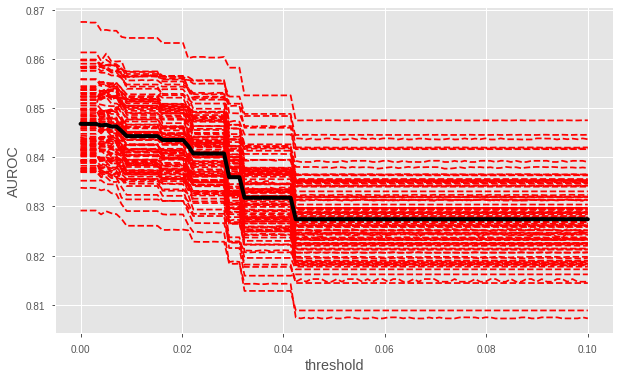

In [78]:
# Compute the average
perf_avg = list(map(np.mean,np.array(out_perf_tot).T))

for perf in out_perf_tot:
    plt.plot(_thrs_array, perf, c='r', linestyle='dashed');
plt.plot(_thrs_array, perf_avg, linewidth=4, c='black');
plt.xlabel('threshold');
plt.ylabel('AUROC');

In [82]:
idx_max_list = []
delta_perf_list = []

for idx in range(0,(np.array(out_perf_tot)).shape[0]): 
    idx_max_list.append(np.argmax(np.array(out_perf_tot[idx])))
    delta_perf = np.max(np.array(out_perf_tot[idx])) - np.array(out_perf_tot[idx])[0]
    delta_perf_list.append(delta_perf)

In [83]:
thrs_delta_perf_df = pd.DataFrame({'thrsh_pos':idx_max_list, 'delta_perf':delta_perf_list})

In [84]:
thrs_delta_perf_df.head()

thrsh_pos  delta_perf
0          6    0.002665
1          0    0.000000
2          6    0.000659
3          0    0.000000
4          5    0.000240

In [85]:
thrs_delta_perf_df['delta_perf_perc'] = thrs_delta_perf_df['delta_perf']*100

In [86]:
delta_perf_df = thrs_delta_perf_df.groupby('thrsh_pos', as_index=True).agg(avg_delta_perf_perc=('delta_perf_perc','mean'),
                                                                            std_delta_perf_perc=('delta_perf_perc','std'),
                                                                            count=('delta_perf_perc','size'))

delta_perf_df['count_perc'] = 100*delta_perf_df['count']/(delta_perf_df['count'].sum())

delta_perf_df.sort_values(by='avg_delta_perf_perc',ascending=False)

avg_delta_perf_perc  std_delta_perf_perc  count  count_perc
thrsh_pos                                                             
7                     0.104091             0.091144     11        11.0
6                     0.082252             0.081894      8         8.0
8                     0.077556             0.056537      7         7.0
10                    0.072915                  NaN      1         1.0
5                     0.067093             0.040677     14        14.0
21                    0.047921                  NaN      1         1.0
4                     0.037191             0.026798      9         9.0
1                     0.003005             0.002688      7         7.0
3                     0.002469             0.003330      2         2.0
2                     0.001430             0.001158      5         5.0
0                     0.000000             0.000000     35        35.0

In [87]:
delta_perf_df['count'].sum()

100

## Logit from statsmodels

In [109]:
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [99]:
gbm_feat_imp_df.head(n=20)

feature  importance
1                                tenure    0.249398
3                          TotalCharges    0.184731
2                        MonthlyCharges    0.174197
10          InternetService_Fiber optic    0.127464
28       PaymentMethod_Electronic check    0.041982
25                    Contract_Two year    0.032012
24                    Contract_One year    0.029053
13                   OnlineSecurity_Yes    0.021773
26                 PaperlessBilling_Yes    0.021126
19                      TechSupport_Yes    0.015244
14     OnlineBackup_No internet service    0.008648
21                      StreamingTV_Yes    0.008456
15                     OnlineBackup_Yes    0.007867
23                  StreamingMovies_Yes    0.007749
0                         SeniorCitizen    0.007538
6                        Dependents_Yes    0.007259
22  StreamingMovies_No internet service    0.006896
4                           gender_Male    0.006111
5                           Partner_Yes    0.005934
9                     MultipleLines_Yes    0.005930

In [141]:
formula = """Churn ~ tenure + TotalCharges + MonthlyCharges + Q('InternetService_Fiber optic') + Q('PaymentMethod_Electronic check') + Q('Contract_Two year')
+ tenure * Q('PaperlessBilling_Yes')"""

logit_model = smf.logit(formula=formula, data=train_df)
logit_output = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.429094
         Iterations 8


In [142]:
logit_output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4930
Model:                          Logit   Df Residuals:                     4921
Method:                           MLE   Df Model:                            8
Date:                Tue, 03 Dec 2019   Pseudo R-squ.:                  0.2609
Time:                        14:21:29   Log-Likelihood:                -2115.4
converged:                       True   LL-Null:                       -2862.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -1.4425      0.165     -8.753      0.000      -1.765      -1.119
tenure                                 -0.0528      0.007     -7.625      0.000      -0.066      -0.039
TotalCharges                            0.0002   7.98e-05      2.399      0.016    3.51e-05       0.000
MonthlyCharges                          0.0087      0.003      2.721      0.007       0.002       0.015
Q('InternetService_Fiber optic')        0.8276      0.141      5.859      0.000       0.551       1.104
Q('PaymentMethod_Electronic check')     0.6038      0.080      7.550      0.000       0.447       0.761
Q('Contract_Two year')                 -1.2990      0.194     -6.686      0.000      -1.680      -0.918
Q('PaperlessBilling_Yes')               0.5496      0.124      4.446      0.000       0.307       0.792
tenure:Q('PaperlessBilling_Yes')       -0.0031      0.004     -0.712      0.476      -0.012       0.005
=======================================================================================================
"""

In [143]:
prediction_logit = logit_output.predict(test_df)

In [144]:
fpr_logit_test, tpr_logit_test, thrsh_logit_test = roc_curve(y_test, prediction_logit)

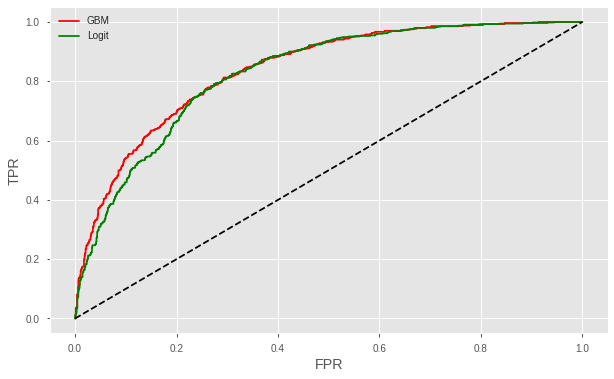

In [145]:
plt.plot(fpr_gbm_test, tpr_gbm_test, c='r', label='GBM');
plt.plot(fpr_logit_test, tpr_logit_test, c='g', label='Logit');
plt.xlabel("FPR");plt.ylabel("TPR");
plt.plot(np.linspace(0,1,100),list(map(lambda x: x,np.linspace(0,1,100))),'--',c='black');

plt.legend();

In [146]:
print("AUROC GBM (test) --> {:3.1f}%".format(auc(fpr_gbm_test, tpr_gbm_test)*100))
print("AUROC Logit (test) --> {:3.1f}%".format(auc(fpr_logit_test, tpr_logit_test)*100))

AUROC GBM (test) --> 83.9%
AUROC Logit (test) --> 82.7%


## XGBoost on churn_df

In [162]:
xgb_model = xgb.XGBClassifier(n_estimators=500, 
                              subsample=1.0,
                              min_child_weight=1,
                              max_depth=3,
                              gamma=0.5,
                              colsample_bytree=0., 
                              learning_rate=0.1)

In [178]:
xgb_model.fit(X_train.values, y_train.values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.0, gamma=0.5,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1.0, verbosity=1)

In [180]:
xgb_model.score(X_test.values, y_test.values)

0.7908187411263606

In [182]:
prediction_xgb = xgb_model.predict_proba(X_test.values)[:,1]

In [183]:
fpr_xgb_test, tpr_xgb_test, thrsh_xgb_test = roc_curve(y_test, prediction_xgb)

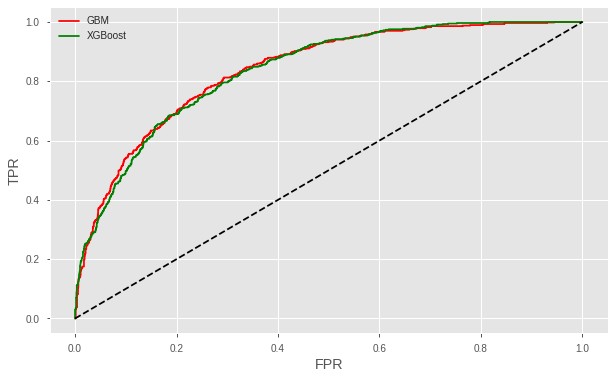

In [184]:
plt.plot(fpr_gbm_test, tpr_gbm_test, c='r', label='GBM');
plt.plot(fpr_xgb_test, tpr_xgb_test, c='g', label='XGBoost');
plt.xlabel("FPR");plt.ylabel("TPR");
plt.plot(np.linspace(0,1,100),list(map(lambda x: x,np.linspace(0,1,100))),'--',c='black');

plt.legend();

In [185]:
print("AUROC XGBoost (test) --> {:3.1f}%".format(auc(fpr_xgb_test, tpr_xgb_test)*100))

AUROC XGBoost (test) --> 83.6%


In [186]:
pd.DataFrame({'feature':features,'importance':xgb_model.feature_importances_}).sort_values(by='importance',ascending=False).head(n=10)

feature  importance
12    OnlineSecurity_No internet service    0.113413
10           InternetService_Fiber optic    0.109534
16  DeviceProtection_No internet service    0.106056
28        PaymentMethod_Electronic check    0.099979
11                    InternetService_No    0.066525
25                     Contract_Two year    0.058442
13                    OnlineSecurity_Yes    0.058278
20       StreamingTV_No internet service    0.039627
19                       TechSupport_Yes    0.038213
0                          SeniorCitizen    0.034587

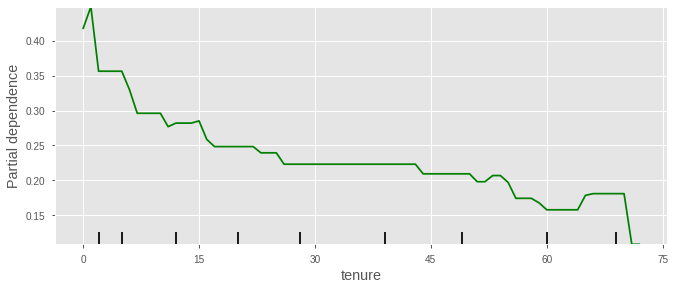

In [187]:
# Tenure

plot_partial_dependence(xgb_model, X_test, [1], feature_names=features);

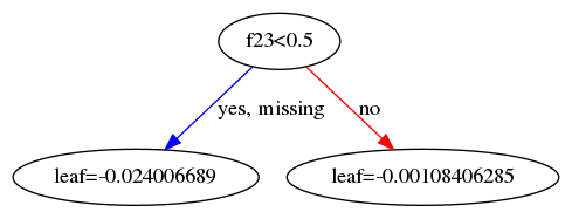

In [192]:
xgb.plot_tree(xgb_model,num_trees=20);

In [190]:
xgb_params = {'colsample_bytree':0.7,'max_depth':3}
data_dmatrix = xgb.DMatrix(data=X,label=y)

xgb_cv_results = xgb.cv(dtrain=data_dmatrix, params=xgb_params, nfold=3,
                        num_boost_round=100,early_stopping_rounds=10,metrics="auc", as_pandas=True, seed=7610)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [191]:
xgb_cv_results

train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.810180       0.002995       0.802510      0.012720
1         0.831834       0.004326       0.823174      0.004445
2         0.837873       0.005363       0.828672      0.004609
3         0.843561       0.003054       0.835068      0.005487
4         0.846948       0.003973       0.837740      0.005763
5         0.849797       0.003972       0.839502      0.006555
6         0.852423       0.003418       0.840628      0.006987
7         0.853554       0.003455       0.841230      0.006495
8         0.855237       0.003519       0.841817      0.006116
9         0.856879       0.003368       0.843327      0.005914
10        0.858604       0.003225       0.843666      0.005852
11        0.859639       0.003136       0.843683      0.005627
12        0.861406       0.003228       0.844537      0.005817
13        0.862623       0.003114       0.844659      0.005444

### Hyperparameters Tuning

In [229]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.3, 0,5, 0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 8, 10]
        }

In [278]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb_model, 
                                   param_distributions=params, 
                                   n_iter=param_comb, scoring='roc_auc', 
                                   n_jobs=4, cv=skf.split(X,y), verbose=3, random_state=1001)

random_search.fit(X, y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   22.9s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fa73a0c4938>,
                   error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=0.6, gamma=5,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=5, min_child_weight=5,
                                           missing=None, n_estimators=500,
                                           n_jobs=1, nthread=None,
                                           obje...
                                           seed=None, silent=None,
                                           subsample=0.8, verbosity=1),
                   iid='warn', n_iter=5, n_jobs=4,
                   param_distributions={'colsample_byt

In [279]:
random_search.best_params_

{'subsample': 1.0,
 'min_child_weight': 1,
 'max_depth': 3,
 'gamma': 0.5,
 'colsample_bytree': 0}

In [268]:
random_search.best_score_

0.8477353173516398

## SVM on churn_df

In [215]:
svm_model = svm.SVC(gamma='auto', C=0.1, kernel='linear', probability=True)

In [216]:
%%time

svm_model.fit(X_train, y_train)

CPU times: user 24min 3s, sys: 525 ms, total: 24min 4s
Wall time: 24min 7s


SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [217]:
svm_model.score(X_test, y_test)

0.8163748225272125

In [208]:
prediction_svm = svm_model.predict_proba(X_test)[:,1]

In [209]:
fpr_svm_test, tpr_svm_test, thrsh_svm_test = roc_curve(y_test, prediction_svm)

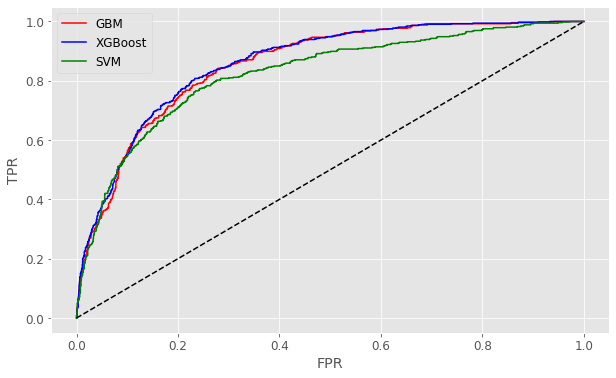

In [210]:
plt.plot(fpr_gbm_test, tpr_gbm_test, c='r', label='GBM');
plt.plot(fpr_xgb_test, tpr_xgb_test, c='blue', label='XGBoost');
plt.plot(fpr_svm_test, tpr_svm_test, c='g', label='SVM');
plt.xlabel("FPR");plt.ylabel("TPR");
plt.plot(np.linspace(0,1,100),list(map(lambda x: x,np.linspace(0,1,100))),'--',c='black');

plt.legend();

In [211]:
print("AUROC SVM (test) --> {:3.1f}%".format(auc(fpr_svm_test, tpr_svm_test)*100))

AUROC SVM (test) --> 82.3%


In [194]:
grid_parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10]}

svm_grid = GridSearchCV(svm_model, grid_parameters, cv=5)
svm_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [195]:
svm_grid.best_score_

0.7975659229208925

In [196]:
svm_grid.cv_results_

{'mean_fit_time': array([1.14073404e+03, 4.73909707e+00, 2.73682933e+03, 7.09167142e+00,
        6.15848878e+03, 5.67218971e+00]),
 'std_fit_time': array([8.17041516e+01, 1.99752524e-01, 1.75060139e+02, 1.14517822e+00,
        4.43971911e+03, 2.43137369e-01]),
 'mean_score_time': array([0.06042242, 0.16780534, 0.04572539, 0.23291693, 0.04081178,
        0.16320472]),
 'std_score_time': array([0.00667445, 0.00913843, 0.00334698, 0.09455488, 0.00624815,
        0.00333813]),
 'param_C': masked_array(data=[0.1, 0.1, 1, 1, 10, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['linear', 'rbf', 'linear', 'rbf', 'linear', 'rbf'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.1, 'kernel': 'linear'},
  {'C': 0.1, 'kernel': 'rbf'},
  {'C': 1, 'kernel': 'linear'},
  {'C': 1, 'kernel': 'rbf'},
  {'C': 10, 

In [197]:
svm_grid.best_params_

{'C': 0.1, 'kernel': 'linear'}

## RandomForest on churn_df

In [193]:
rf_model = RandomForestClassifier(n_estimators=100, 
                                  max_depth=5, 
                                  n_jobs=4)

In [194]:
rf_model.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 4,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [195]:
%%time

rf_model.fit(X_train, y_train)

CPU times: user 519 ms, sys: 60.4 ms, total: 579 ms
Wall time: 556 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [196]:
rf_model.score(X_test, y_test)

0.791292001893043

In [197]:
prediction_rf = rf_model.predict_proba(X_test)[:,1]

In [198]:
fpr_rf_test, tpr_rf_test, thrsh_rf_test = roc_curve(y_test, prediction_rf)

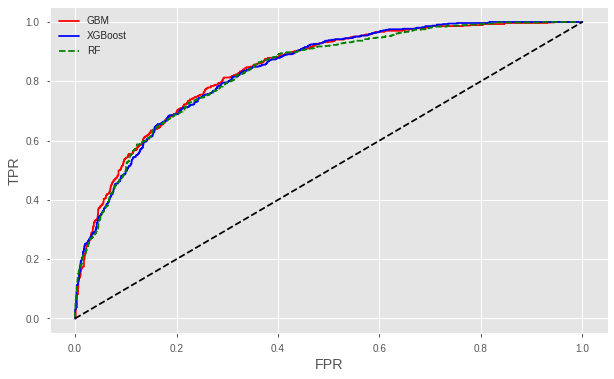

In [199]:
plt.plot(fpr_gbm_test, tpr_gbm_test, c='r', label='GBM');
plt.plot(fpr_xgb_test, tpr_xgb_test, c='blue', label='XGBoost');
#plt.plot(fpr_svm_test, tpr_svm_test, c='g', label='SVM');
plt.plot(fpr_rf_test, tpr_rf_test, '--', c='g',label='RF');
plt.xlabel("FPR");plt.ylabel("TPR");
plt.plot(np.linspace(0,1,100),list(map(lambda x: x,np.linspace(0,1,100))),'--',c='black');

plt.legend();

In [200]:
print("AUROC RF (test) --> {:3.1f}%".format(auc(fpr_rf_test, tpr_rf_test)*100))

AUROC RF (test) --> 83.2%


In [201]:
rf_feat_imp_df = pd.DataFrame({'feature':features,'importance':rf_model.feature_importances_}).sort_values(by='importance',ascending=False)

rf_feat_imp_df.head(n=20)

feature  importance
1                                 tenure    0.211959
10           InternetService_Fiber optic    0.109556
3                           TotalCharges    0.108425
25                     Contract_Two year    0.103993
28        PaymentMethod_Electronic check    0.079469
2                         MonthlyCharges    0.060592
24                     Contract_One year    0.050472
19                       TechSupport_Yes    0.034972
13                    OnlineSecurity_Yes    0.031013
16  DeviceProtection_No internet service    0.030668
11                    InternetService_No    0.028761
22   StreamingMovies_No internet service    0.025403
14      OnlineBackup_No internet service    0.020552
12    OnlineSecurity_No internet service    0.015559
20       StreamingTV_No internet service    0.013547
18       TechSupport_No internet service    0.010455
26                  PaperlessBilling_Yes    0.009361
15                      OnlineBackup_Yes    0.008759
5                            Partner_Yes    0.006908
0                          SeniorCitizen    0.006574

### Variable Restrictions vs Performance

In [232]:
%%time

rf_restricted_model = RandomForestClassifier(n_estimators=100, max_depth=5,
                                             n_jobs=4)

_thrs_array = np.linspace(0, 0.1, 30)
out_perf_tot = []
nsim = 100

# Progress Bar 
f = FloatProgress(min=0, max=nsim, bar_style='info')
display(f)

for s in np.random.randint(1000,2000,nsim):
    out_perf_list = []
    for _thrsh in _thrs_array:
        
        restricted_features = rf_feat_imp_df[rf_feat_imp_df.importance >= _thrsh]['feature'].values
        X_restricted = churn_df[restricted_features].values

        X_restricted_train, X_restricted_test, y_train, y_test = train_test_split(X_restricted, y, test_size = 0.3, random_state = s)

        rf_restricted_model.fit(X_restricted_train, y_train)
        prediction_rf_restricted = rf_restricted_model.predict_proba(X_restricted_test)[:,1]

        fpr_rf_restricted_test, tpr_rf_restricted_test, thrsh_rf_restricted_test = roc_curve(y_test, prediction_rf_restricted)
        out_perf = auc(fpr_rf_restricted_test, tpr_rf_restricted_test)
        out_perf_list.append(out_perf)

    f.value += 1
    out_perf_tot.append(out_perf_list)

FloatProgress(value=0.0, bar_style='info')

CPU times: user 34min 10s, sys: 5min 8s, total: 39min 19s
Wall time: 1h 11min 23s


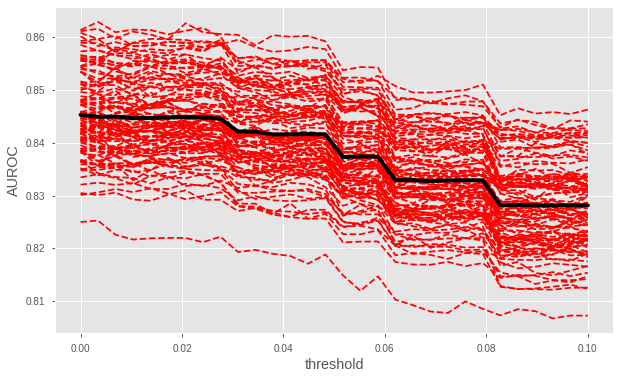

In [233]:
# Compute the average
perf_avg = list(map(np.mean,np.array(out_perf_tot).T))

for perf in out_perf_tot:
    plt.plot(_thrs_array, perf, c='r', linestyle='dashed');
plt.plot(_thrs_array, perf_avg, linewidth=4, c='black');
plt.xlabel('threshold');
plt.ylabel('AUROC');

In [234]:
idx_max_list = []
delta_perf_list = []

for idx in range(0,(np.array(out_perf_tot)).shape[0]): 
    idx_max_list.append(np.argmax(np.array(out_perf_tot[idx])))
    delta_perf = np.max(np.array(out_perf_tot[idx])) - np.array(out_perf_tot[idx])[0]
    delta_perf_list.append(delta_perf)

In [235]:
thrs_delta_perf_df = pd.DataFrame({'thrsh_pos':idx_max_list, 'delta_perf':delta_perf_list})

In [236]:
thrs_delta_perf_df['delta_perf_perc'] = thrs_delta_perf_df['delta_perf']*100

In [239]:
delta_perf_df = thrs_delta_perf_df.groupby('thrsh_pos', as_index=True).agg(avg_delta_perf_perc=('delta_perf_perc','mean'),
                                                                            std_delta_perf_perc=('delta_perf_perc','std'),
                                                                            count=('delta_perf_perc','size'))

delta_perf_df['count_perc'] = 100*delta_perf_df['count']/(delta_perf_df['count'].sum())

delta_perf_df.sort_values(by='count_perc', ascending=False)

avg_delta_perf_perc  std_delta_perf_perc  count  count_perc
thrsh_pos                                                             
0                     0.000000             0.000000     28        28.0
1                     0.083005             0.055228     17        17.0
2                     0.101031             0.086202     11        11.0
4                     0.113141             0.130509      7         7.0
6                     0.153407             0.129557      7         7.0
3                     0.074178             0.078522      6         6.0
5                     0.228026             0.111170      6         6.0
7                     0.089027             0.055348      6         6.0
8                     0.202863             0.109352      6         6.0
10                    0.304286             0.163456      4         4.0
9                     0.372792                  NaN      1         1.0
13                    0.200186                  NaN      1         1.0

## GBM on augmented dataset churn_df

In [330]:
gbm_model = GradientBoostingClassifier(n_estimators=100, 
                                       max_depth=5,
                                       subsample=0.6)

In [344]:
gbm_model.fit(X_train_augmented, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.6, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [345]:
gbm_model.score(X_test_augmented, y_test)

0.7946048272598202

In [346]:
prediction_gbm = gbm_model.predict_proba(X_test_augmented)[:,1]
train_gbm = gbm_model.predict_proba(X_train_augmented)[:,1]

In [347]:
fpr_gbm_test, tpr_gbm_test, thrsh_gbm_test = roc_curve(y_test, prediction_gbm)
fpr_gbm_train, tpr_gbm_train, thrsh_gbm_train = roc_curve(y_train, train_gbm)

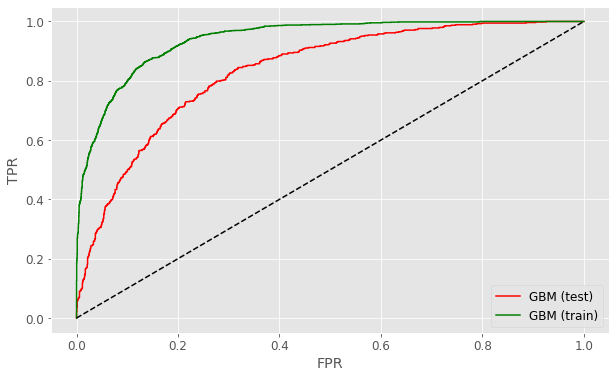

In [348]:
plt.plot(fpr_gbm_test, tpr_gbm_test, c='r', label='GBM (test)');
plt.plot(fpr_gbm_train, tpr_gbm_train, c='g', label='GBM (train)');
plt.xlabel("FPR");plt.ylabel("TPR");
plt.plot(np.linspace(0,1,100),list(map(lambda x: x,np.linspace(0,1,100))),'--',c='black');

plt.legend();

In [349]:
print("AUROC GBM (test) --> {:3.1f}%".format(auc(fpr_gbm_test, tpr_gbm_test)*100))

AUROC GBM (test) --> 83.3%


In [350]:
gbm_feat_imp_df = pd.DataFrame({'feature':features_augmented,'importance':gbm_model.feature_importances_}).sort_values(by='importance',ascending=False)

gbm_feat_imp_df.head(n=20)

feature  importance
4                            TotalCharges    0.201303
3                          MonthlyCharges    0.178597
2                             new_feature    0.151035
11            InternetService_Fiber optic    0.112057
1                                  tenure    0.076076
29         PaymentMethod_Electronic check    0.041175
26                      Contract_Two year    0.034126
27                   PaperlessBilling_Yes    0.026227
25                      Contract_One year    0.025534
20                        TechSupport_Yes    0.018136
0                           SeniorCitizen    0.016947
10                      MultipleLines_Yes    0.016786
5                             gender_Male    0.012259
14                     OnlineSecurity_Yes    0.011668
24                    StreamingMovies_Yes    0.009621
22                        StreamingTV_Yes    0.009600
16                       OnlineBackup_Yes    0.009316
28  PaymentMethod_Credit card (automatic)    0.006603
7                          Dependents_Yes    0.006514
30             PaymentMethod_Mailed check    0.006214

***